improve plotting

In [1]:
from pathlib import Path
from typing import Iterable, List, Optional, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
from dvclive import Live

In [2]:
%load_ext watermark
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

segmentation_models_pytorch: 0.3.3
rasterio                   : 1.3.9
torchgeo                   : 0.5.2
matplotlib                 : 3.7.3
torch                      : 2.4.0.dev20240405+cu121



# Visualise a single image

In [3]:
from pathlib import  Path
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
assert root.exists()

train_imgs = list((root/'images').glob('*.tif'))
train_masks = list((root/'masks').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()

In [4]:
idx = 0
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

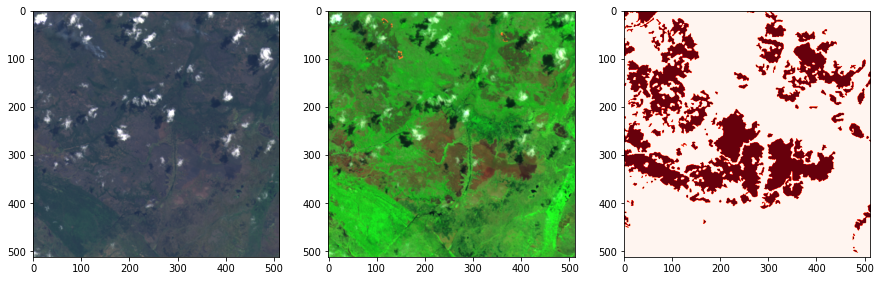

In [5]:
_, axs = plt.subplots(1, 3, figsize=(15, 6))

# plot the tile
FCI = [6,4,3]
TCI = [3, 2, 1]

rgb = img.data[TCI].transpose((1, 2, 0))/17000
axs[0].imshow(rgb.clip(min=0, max=1))

rgb = img.data[FCI].transpose((1, 2, 0))/25000
axs[1].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[2].imshow(mask.data.squeeze(), cmap='Reds')

In [6]:
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples

train_ds = RasterDataset(paths=(root/'images').as_posix(), crs='epsg:4326', res= 0.00025)

In [7]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size= 512, length= 100)

In [8]:
import torch 

# this is to get the same result in every pass
torch.manual_seed(0)

bbox = next(iter(sampler))
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

dict_keys(['crs', 'bbox', 'image'])
torch.Size([8, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


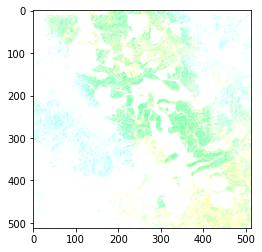

In [10]:
import torch
import matplotlib.pyplot as plt

arr = torch.clamp(sample['image']/10000, min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [6, 4, 3]]

plt.imshow(rgb*3)

In [11]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

# Creating the datasets

In [ ]:
import os
import shutil
import random
from tqdm.auto import tqdm

def split_data(root, image_folder, mask_folder, train_ratio=0.8, seed=None):
    # Create train and test directories if they don't exist
    train_dir = os.path.join(root, 'train')
    test_dir = os.path.join(root, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create image and mask folders within train and test directories
    train_image_dir = os.path.join(train_dir, 'images')
    train_mask_dir = os.path.join(train_dir, 'masks')
    test_image_dir = os.path.join(test_dir, 'images')
    test_mask_dir = os.path.join(test_dir, 'masks')
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Get list of TIFF image filenames
    image_filenames = [filename for filename in os.listdir(os.path.join(root, image_folder)) if filename.endswith('.tif')]

    # Set random seed for reproducibility
    random.seed(seed)

    # Randomly shuffle filenames
    random.shuffle(image_filenames)

    # Calculate number of samples for train and test
    num_samples = len(image_filenames)
    num_train_samples = int(num_samples * train_ratio)
    num_test_samples = num_samples - num_train_samples

    # Split images into train and test sets
    train_images = image_filenames[:num_train_samples]
    test_images = image_filenames[num_train_samples:]

    # Move images and masks to train and test directories
    for image_name in tqdm(train_images, desc='Copying train images and masks'):
        shutil.copy(os.path.join(root, image_folder, image_name), os.path.join(train_image_dir, image_name))
        mask_name = image_name.replace('.tif', '_mask.tif')
        shutil.copy(os.path.join(root, mask_folder, mask_name), os.path.join(train_mask_dir, mask_name))

    for image_name in tqdm(test_images, desc='Copying test images and masks'):
        shutil.copy(os.path.join(root, image_folder, image_name), os.path.join(test_image_dir, image_name))
        mask_name = image_name.replace('.tif', '_mask.tif')
        shutil.copy(os.path.join(root, mask_folder, mask_name), os.path.join(test_mask_dir, mask_name))

    print("Data split completed. Train samples:", num_train_samples, "Test samples:", num_test_samples)

# Example usage
dirname = r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data"
split_data(dirname, 'images', 'masks', train_ratio=0.7, seed=42)


Copying train images and masks:   0%|          | 0/158 [00:00<?, ?it/s]

Copying test images and masks:   0%|          | 0/69 [00:00<?, ?it/s]

Data split completed. Train samples: 158 Test samples: 69


In [12]:
def scale(item: dict):
    item['image'] = item['image'] / 65535
    return item

In [13]:
from pathlib import Path
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torch.utils.data import DataLoader

root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
assert root.exists()

train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025, transforms=scale)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False

In [14]:
sampler = RandomGeoSampler(train_imgs, size=512, length=30, units=Units.PIXELS)

In [15]:

# let's get a random bounding box, just to check the datasets
bbox = next(iter(sampler))

In [16]:

img_sample = train_imgs[bbox]
msk_sample = train_msks[bbox]

print(img_sample.keys(), msk_sample.keys())

dict_keys(['crs', 'bbox', 'image']) dict_keys(['crs', 'bbox', 'mask'])


In [17]:

# let's assert the patches cover the same region...
print(img_sample['bbox'])
print(msk_sample['bbox'])
assert img_sample['bbox'] == msk_sample['bbox']

BoundingBox(minx=100.99475000000001, maxx=101.12275000000001, miny=1.0185, maxy=1.1465, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=100.99475000000001, maxx=101.12275000000001, miny=1.0185, maxy=1.1465, mint=0.0, maxt=9.223372036854776e+18)


In [18]:
train_dset = train_imgs & train_msks

In [19]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [20]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [21]:
from typing import Iterable, List
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [6,4,3], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Reds')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [6, 4, 3]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

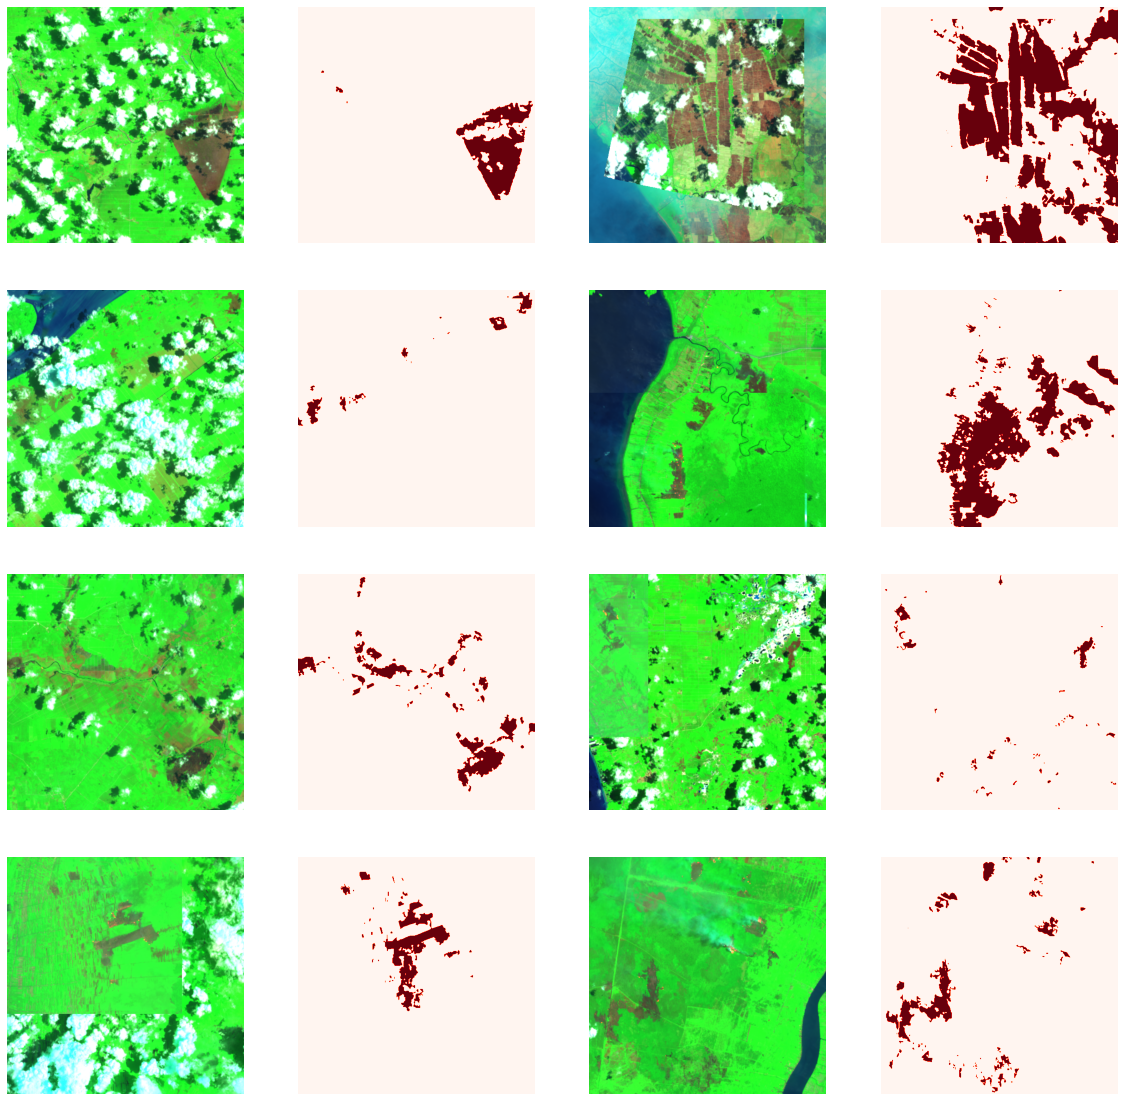

In [22]:
plot_batch(batch)

In [23]:
import rasterio as rio


def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/65535 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)


mean, std = calc_statistics(train_imgs)
print(mean, std)

[0.17668842 0.15675741 0.13778825 0.12055823 0.28241998 0.17191281
 0.09550891 0.00745637] [0.06076501 0.06537632 0.06726206 0.07445835 0.09597592 0.07803526
 0.06030625 0.00284078]


In [24]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs[..., : len(self.mean), :, :]

        # if batch
        if inputs.ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs[..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs[..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs[:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs[..., : len(self.mean), :, :] = x

        return inputs

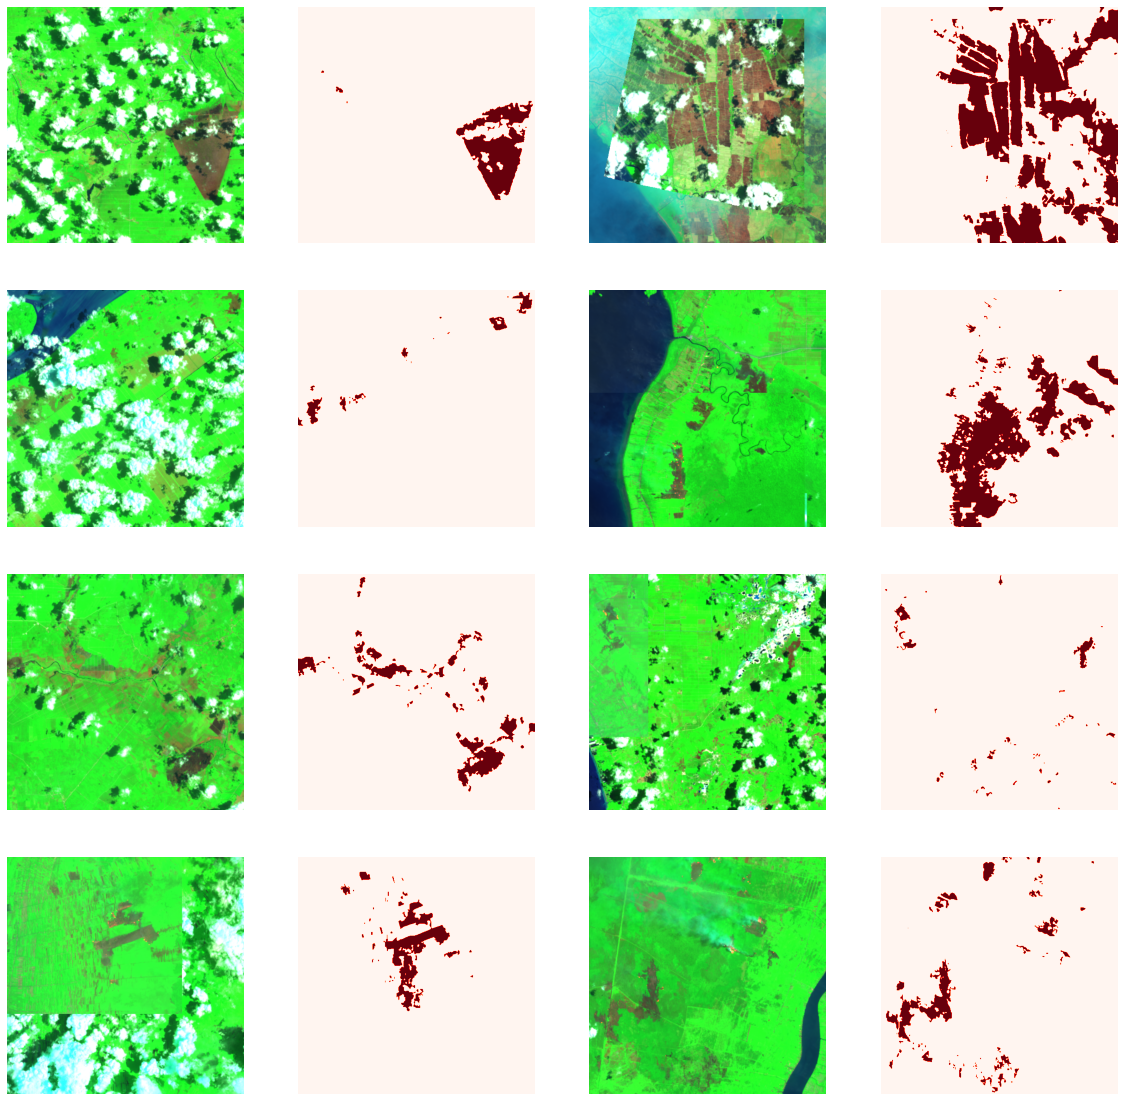

In [25]:
normalize = MyNormalize(mean=mean, stdev=std)
norm_batch = normalize(batch['image'])
# plot_batch(norm_batch)

revert_batch = normalize.revert(norm_batch)
plot_batch(batch)

In [26]:
from torchgeo.transforms import indices

ndwi_transform = indices.AppendNDWI(index_green=2, index_nir=4)

transformed_batch = ndwi_transform(batch['image'])
print(batch['image'].shape)
print(transformed_batch.shape)


torch.Size([8, 8, 512, 512])
torch.Size([8, 9, 512, 512])


In [27]:
from torchgeo.transforms import AugmentationSequential
tfms = AugmentationSequential(
    indices.AppendNDWI(index_green=2, index_nir=4),
    indices.AppendNDVI(index_nir=4, index_red=3),
    normalize,
    data_keys = ["image"]
)

x = batch
print(x['image'].shape)
x = tfms(x)
print(x['image'].shape)

torch.Size([8, 8, 512, 512])
torch.Size([8, 10, 512, 512])


In [28]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [29]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=10,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [30]:
pred = model(torch.randn(3, 10, 512, 512, device = device))
pred.shape

torch.Size([3, 2, 512, 512])

In [35]:
from typing import Dict 
def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch = batch_tfms(batch)

            X = batch['image'].to(device)
            y = batch['mask'].type(torch.long).to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)
        
        model.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).to(device)
                    y = batch['mask'].type(torch.long).to(device)

                    pred = model(X)
                    val_loss = loss_fn(pred, y)
                    accum_val_loss += float(val_loss)/len(val_dl)

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Eval Accs={[round(a, 3) for a in acc]}')
        else:
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.get('metric_index')]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.get("save_model_path"))
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        with Live(save_dvc_exp=True) as live:
            for param_name, param_value in train_params.items():
                live.log_param(param_name, param_value)
            live.log_metric("model_saving_score", chkpt_score)
            live.log_metric("Train loss", accum_loss)
            live.log_metric("Val_loss", accum_val_loss)

In [32]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t.squeeze())

In [33]:
train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025, transforms=scale)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025, transforms=scale)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=512, length=158, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=512, length=69, units=Units.PIXELS)

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [36]:
train_params = {'lr': 0.0001,
                'weight_decay': 0.01,
                'epochs': 20,
                'metric_index': 1,
                'save_model_path': r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_12042024.pth"}

optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
train_loop(epochs = train_params.get('epochs'), train_dl = train_dataloader, val_dl= valid_dataloader, model = model, loss_fn = loss, optimizer = optimizer, 
           acc_fns=[oa, iou], batch_tfms=tfms, train_params = train_params)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.69387 - Eval Accs=[0.694, 0.209]
Saving model with validation score: 0.2093 at epoch 1


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 2: Train Loss=0.55263 - Eval Accs=[0.848, 0.248]
Saving model with validation score: 0.2480 at epoch 2


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 3: Train Loss=0.48002 - Eval Accs=[0.885, 0.341]
Saving model with validation score: 0.3415 at epoch 3


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 4: Train Loss=0.42864 - Eval Accs=[0.905, 0.484]
Saving model with validation score: 0.4845 at epoch 4


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 5: Train Loss=0.38344 - Eval Accs=[0.912, 0.358]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 6: Train Loss=0.33608 - Eval Accs=[0.924, 0.435]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 7: Train Loss=0.29724 - Eval Accs=[0.948, 0.586]
Saving model with validation score: 0.5864 at epoch 7


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 8: Train Loss=0.26799 - Eval Accs=[0.936, 0.51]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 9: Train Loss=0.24774 - Eval Accs=[0.951, 0.565]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 10: Train Loss=0.22953 - Eval Accs=[0.941, 0.572]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 11: Train Loss=0.20818 - Eval Accs=[0.948, 0.558]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 12: Train Loss=0.20177 - Eval Accs=[0.958, 0.66]
Saving model with validation score: 0.6602 at epoch 12


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 13: Train Loss=0.19030 - Eval Accs=[0.951, 0.609]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 14: Train Loss=0.19060 - Eval Accs=[0.934, 0.521]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 15: Train Loss=0.18256 - Eval Accs=[0.953, 0.531]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 16: Train Loss=0.16435 - Eval Accs=[0.965, 0.641]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 17: Train Loss=0.15938 - Eval Accs=[0.953, 0.591]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 18: Train Loss=0.14563 - Eval Accs=[0.937, 0.555]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 19: Train Loss=0.15520 - Eval Accs=[0.934, 0.518]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


Epoch 20: Train Loss=0.13724 - Eval Accs=[0.94, 0.567]


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached '..\components\artifacts'
            git commit -m "stop tracking ..\components\artifacts" 


# Plot predictions

In [37]:
batch = next(iter(train_dataloader))
inB = tfms(batch)['image'].to(device)
out = model(inB)
out.shape

torch.Size([8, 2, 512, 512])

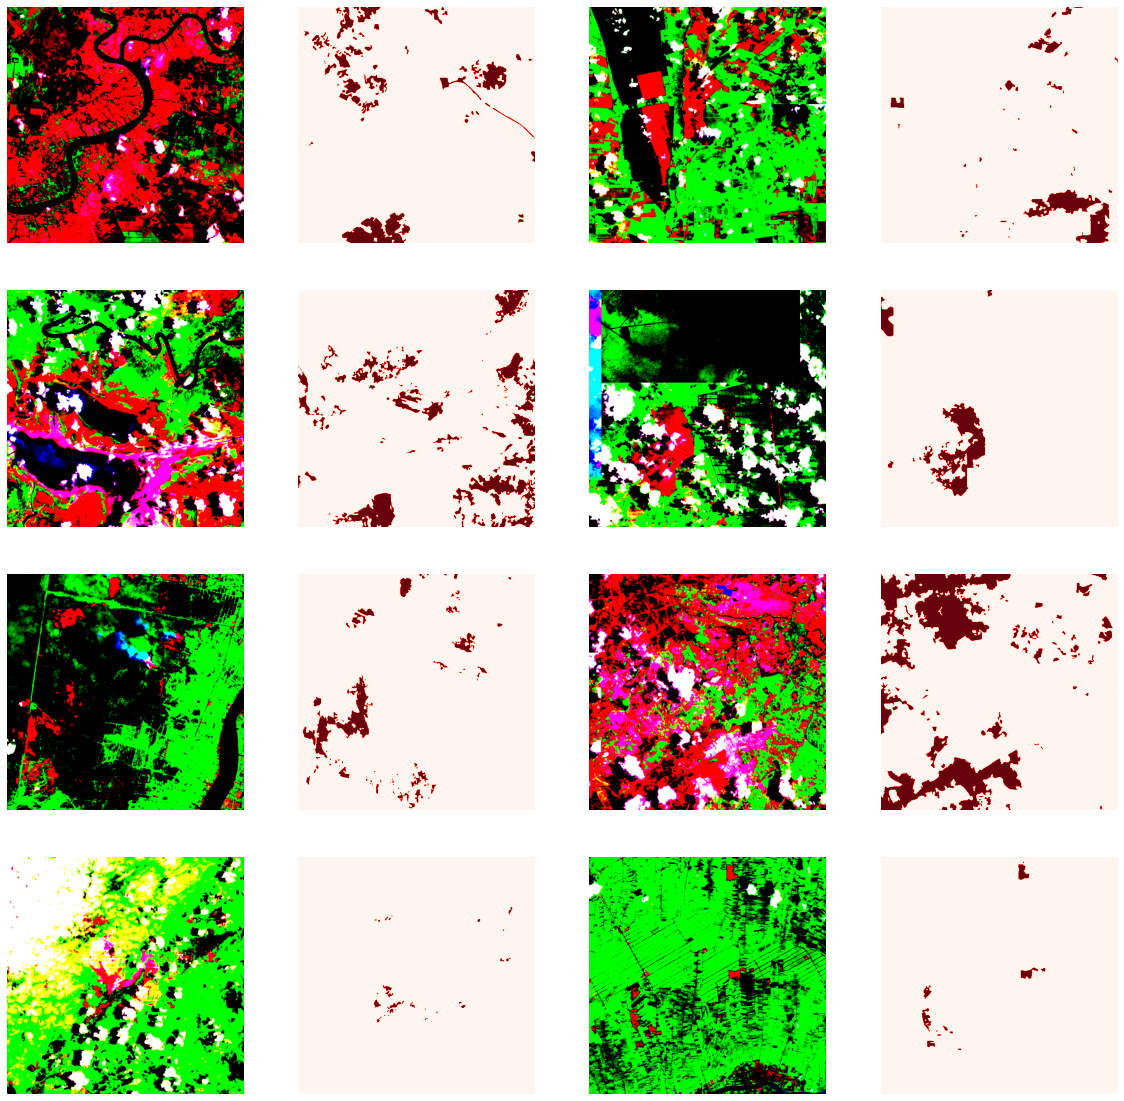

In [38]:
plot_batch(batch)

Text(0.5, 1.0, 'Reference')

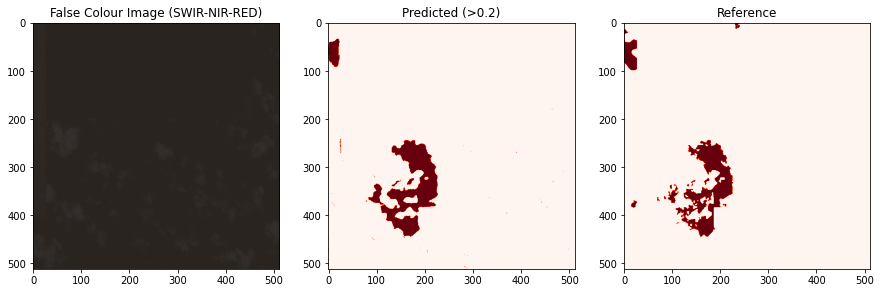

In [40]:
idx = 3
_, axs = plt.subplots(1, 3, figsize=(15, 6))

# Define the labels
labels = ['False Colour Image (SWIR-NIR-RED)', 'Predicted (>0.2)', 'Reference']


# plot the tile
inBatch = normalize.revert(batch['image'])
img = inBatch[idx,1:4,:,:].cpu().numpy()
mask = batch['mask'][idx].cpu().numpy()
# plot the tile
rgb = img.transpose((1, 2, 0))
axs[0].imshow(rgb)
axs[0].set_title(labels[0])

# plot the predicted mask
axs[1].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze()>0.3, cmap='Reds')
axs[1].set_title(labels[1])

# plot the reference mask
axs[2].imshow(mask.squeeze(), cmap='Reds')
axs[2].set_title(labels[2])